### Create the neural network Ansatz

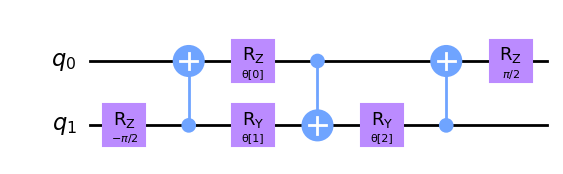

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

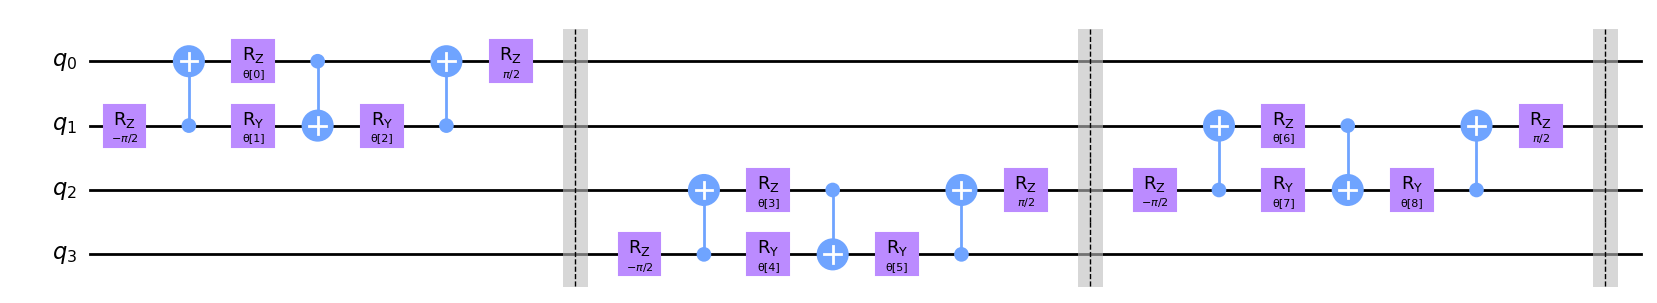

In [2]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

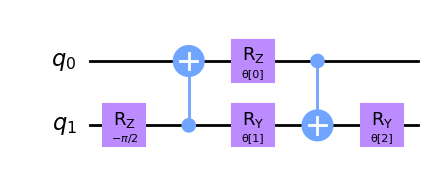

In [3]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

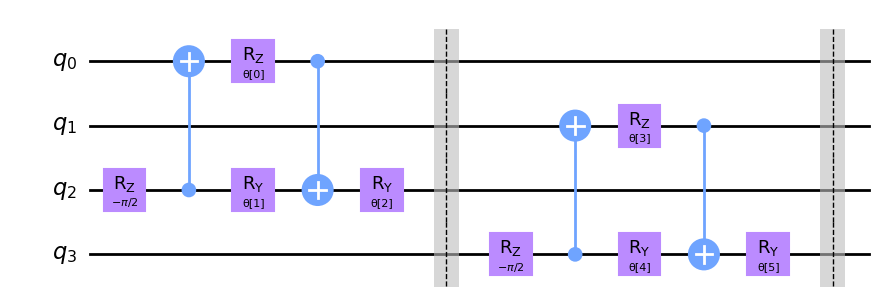

In [4]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

### Generate the data

In [5]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels

In [6]:
from sklearn.model_selection import train_test_split


np.random.seed(12345)
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

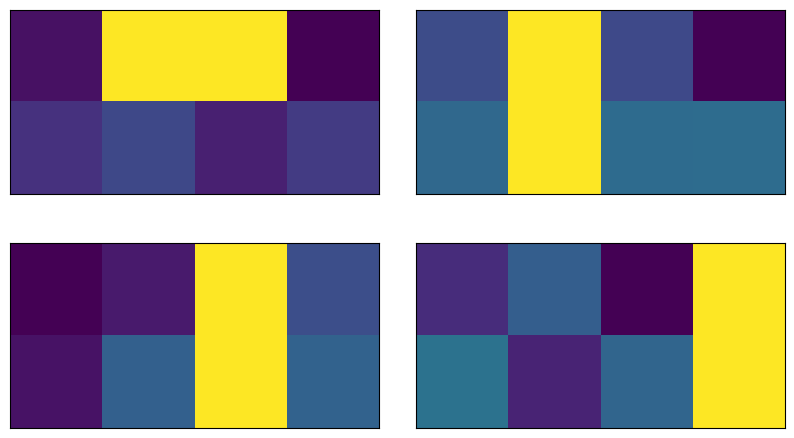

In [7]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

### Create the circuit

In [8]:
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp


feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")
# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)
# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)
# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)
# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

### Load the data and do a forward pass

In [9]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
from typing import Sequence


def forward(circuit: QuantumCircuit,
            input_params: np.ndarray, 
            weight_params: np.ndarray, 
            estimator: BaseEstimatorV2,
            observables: Sequence[BaseOperator] | BaseOperator
) -> np.ndarray:
    """Forward pass of the neural network."""
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    parameters = np.concatenate((input_params, weights), axis=1)
    job = estimator.run(
        [circuit] * num_samples * len(observables),
        [op for op in observables for _ in range(num_samples)],
        np.tile(parameters, (len(observables), 1)),
    )
    results = job.result()
    results_postprocessed = np.reshape(results.values, (-1, num_samples)).T
    
    return results_postprocessed

In [10]:
from qiskit.primitives import Estimator


np.random.seed(12345)

input_params = np.array([train_images[0], train_images[1]])
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
estimator = Estimator()
observables = [observable, observable]

result = forward(circuit, input_params, weight_params, estimator, observables)
print(result)

[[-0.02287969 -0.02287969]
 [ 0.02592446  0.02592446]]


### TODO: Gradient with parameter shift rule

In [11]:
def param_shift_estimator_gradient(circuit: QuantumCircuit,
                                   input_params: np.ndarray, 
                                   weight_params: np.ndarray, 
                                   estimator: BaseEstimatorV2,
                                   observable: BaseOperator
) -> np.ndarray:
    """
    Compute the gradients of the expectation values by the parameter shift rule [1].

    **Reference:**
    [1] Schuld, M., Bergholm, V., Gogolin, C., Izaac, J., and Killoran, N. Evaluating analytic
    gradients on quantum hardware, `DOI <https://doi.org/10.1103/PhysRevA.99.032331>`_
    """
    num_samples = input_params.shape[0]
    num_input_params = input_params.shape[1]
    num_weight_params = len(weight_params)

    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    parameters = np.concatenate((input_params, weights), axis=1)
    job = estimator.run(
        [circuit] * num_samples * len(observables),
        [op for op in observables for _ in range(num_samples)],
        np.tile(parameters, (len(observables), 1)),
    )
    results = job.result()
    results_postprocessed = np.reshape(results.values, (-1, num_samples)).T
    
    return results_postprocessed

In [12]:
np.random.seed(12345)

input_params = np.array([train_images[0], train_images[1]])
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
estimator = Estimator()
observables = [observable, observable]

result = param_shift_estimator_gradient(circuit, input_params, weight_params, estimator, observables)
print(result)

[[-0.02287969 -0.02287969]
 [ 0.02592446  0.02592446]]


### Cost function

In [13]:
def l2_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Compute the L2 loss (i.e. squared error) averaged for each sample.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        return (np.linalg.norm(predict - target, axis=tuple(range(1, len(predict.shape)))) ** 2).mean()

In [14]:
loss = l2_loss(predict=np.array([-1, -1]), target=np.array([1, -1]))
print(loss)

2.0


In [15]:
def cost_function(weight_params: np.ndarray
) -> np.ndarray:
    result = forward(circuit, input_params, weight_params, estimator, observables)
    predictions = np.squeeze(result)
    cost = l2_loss(predictions, target)
    print(f"Loss: {cost}")

    return cost

### Optimizer

In [16]:
batch_size = 2
train_images_batch = np.array(train_images[:batch_size])
train_labels_batch = np.array(train_labels[:batch_size])
print(train_labels_batch)

predictions = forward(circuit, train_images_batch, weight_params, estimator, observable)
predictions = np.squeeze(predictions)
print(predictions)

loss = l2_loss(predict=predictions, target=train_labels_batch)
print(loss)

[-1  1]
[-0.02287969  0.02592446]
0.9517936247098779


In [17]:
# Globals
circuit = circuit
input_params = input_params
estimator = estimator
observables = observable
target = train_labels_batch
loss = "l2"

print(cost_function(weight_params))

Loss: 0.9517936247098779
0.9517936247098779


In [18]:
from scipy.optimize import minimize


res = minimize(cost_function, weight_params, method='COBYLA')
print(res)

Loss: 0.9517936247098779
Loss: 1.0537087100023022
Loss: 1.0067750844100236
Loss: 1.0746743740412827
Loss: 0.9855316855888956
Loss: 1.054188325103446
Loss: 0.9131617584830133
Loss: 0.8412415853262231
Loss: 0.8330716576908552
Loss: 0.8403472587922948
Loss: 0.7855212333407267
Loss: 0.8297178416954447
Loss: 0.8665811443910955
Loss: 0.807065976626546
Loss: 0.9315954734284633
Loss: 0.8313494808183246
Loss: 0.7305685877064785
Loss: 0.686645665176046
Loss: 0.8738703741096653
Loss: 0.753858466273241
Loss: 0.8253557020939117
Loss: 0.7678631734347873
Loss: 0.8377492252837965
Loss: 0.686645665176046
Loss: 0.5698742729314054
Loss: 0.6319066753812468
Loss: 0.5698742729314051
Loss: 0.706406030947049
Loss: 0.6436909097640868
Loss: 0.5698742729314054
Loss: 0.5940952161141495
Loss: 0.6123487112429176
Loss: 0.5698742729314055
Loss: 0.6047001887135919
Loss: 0.5823891880804334
Loss: 0.5698742729314054
Loss: 0.795206495069406
Loss: 0.8703980459467855
Loss: 0.5698742729314052
Loss: 0.8521688610749469
Loss: 0

### Accuracy

In [21]:
print(res['x'])
predictions = np.squeeze(forward(circuit, train_images_batch, res['x'], estimator, observable))
print(predictions)

[ 5.02326257  3.06283702  1.38182466  1.54450187  3.07836858  4.57461344
  6.47865503  4.66062362  4.7103923   4.722755    4.54067805  6.30935011
 -0.18231362  1.33461476  1.51260037  4.73524119  5.11706412  6.31869498
  6.29054831  4.54755526  4.22990776  4.6922426   2.99595948  2.68348144
  2.82599779  6.20590532  6.3214592   3.88503123  4.8918663   1.51607747
  0.08125253  5.33717374  6.30706615  0.33516273  2.75799355  3.15496591
  2.8622789   0.16785085  4.99125167  4.6877493   5.30977222  3.2161139
  6.27255698  0.9867784   1.29290985  1.91528046  2.59696195  2.65732047
  4.68513765  1.33559083  3.3136788   1.10011271  4.7817242   7.05627938]
[-0.67260637  0.60126545]


In [22]:
predictions[predictions >= 0] = 1
predictions[predictions < 0] = -1
print(predictions)

[-1.  1.]


In [24]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(train_labels_batch, predictions)
print(accuracy)


2.0
